In [25]:
import pandas as pd
#file
file_path = "SentimentData.txt"
# load file
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()
# Convert to dataframe data
data = pd.DataFrame(lines, columns=['raw_text'])
# Split labels and reviews
data[['Labels', 'Review']] = data['raw_text'].str.split(' ', n=1, expand=True)
# Replace the label with 1 or 2
data['Labels'] = data['Labels'].apply(lambda x: x.replace('__label__', '') if isinstance(x, str) else x)
# Drop the original raw text column
data = data.drop(columns=['raw_text'])
print(data.head())

  Labels                                             Review
0      2  Great CD: My lovely Pat has one of the GREAT v...
1      2  One of the best game music soundtracks - for a...
2      1  Batteries died within a year ...: I bought thi...
3      2  works fine, but Maha Energy is better: Check o...
4      2  Great for the non-audiophile: Reviewed quite a...


In [27]:
data.shape
data=data.head(10000)

In [29]:
import os
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
#text preprocessing function
#text preprocessing function
def preprocess_text(text):
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text.lower())
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)
# preprocess all reviews
data['processed_review'] = data['Review'].apply(preprocess_text)
data[['Review', 'processed_review']].head()

,Review,processed_review
0,Great CD: My lovely Pat has one of the GREAT v...,great cd lovely pat one great voice generation...
1,One of the best game music soundtracks - for a...,one best game music soundtrack game didnt real...
2,Batteries died within a year ...: I bought thi...,battery died within year bought charger jul 20...
3,"works fine, but Maha Energy is better: Check o...",work fine maha energy better check maha energy...
4,Great for the non-audiophile: Reviewed quite a...,great nonaudiophile reviewed quite bit combo p...


In [31]:
X = data['processed_review']
y = data['Labels']
#split data for test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("TF-IDF Training shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

TF-IDF Training shape: (8000, 5000)
TF-IDF Test shape: (2000, 5000)


In [35]:
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
'n_estimators': [100, 200],
'max_depth': [None, 10, 20],
'min_samples_split': [2, 5],
'min_samples_leaf': [1, 2]
}
# GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_tfidf, y_train)
# display best paarameters
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best score for Random Forest:", grid_search_rf.best_score_)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best score for Random Forest: 0.83475


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Best parameters from GridSearchCV
best_params_rf = {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

# Initialize the Random Forest model with the best parameters
rf_best = RandomForestClassifier(**best_params_rf, random_state=42)

# Fit the model
rf_best.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = rf_best.predict(X_test_tfidf)

# Model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print results
print("Accuracy of the best Random Forest model:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Accuracy of the best Random Forest model: 0.833
Confusion Matrix:
 [[785 182]
 [152 881]]
Classification Report:
               precision    recall  f1-score   support

           1       0.84      0.81      0.82       967
           2       0.83      0.85      0.84      1033

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



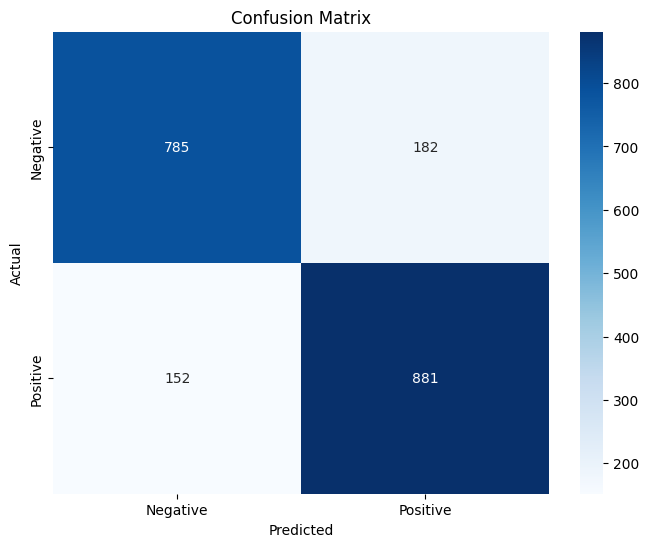

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

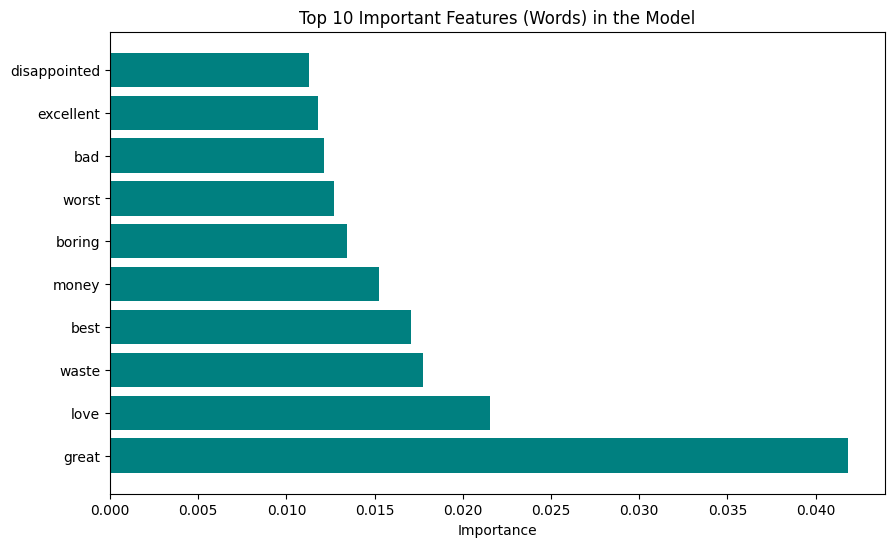

In [53]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Feature importance
importances = rf_best.feature_importances_
indices = importances.argsort()[-10:][::-1]  # Get the indices of the top 10 important features

# Get the corresponding feature names (words)
top_features = [vectorizer.get_feature_names_out()[i] for i in indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features, importances[indices], color='teal')
plt.xlabel('Importance')
plt.title('Top 10 Important Features (Words) in the Model')
plt.show()


In [69]:
print(data['Labels'].value_counts())
data['processed_review']

Labels
2    5125
1    4875
Name: count, dtype: int64


0     great cd lovely pat one great voice generation...
1     one best game music soundtrack game didnt real...
2     battery died within year bought charger jul 20...
3     work fine maha energy better check maha energy...
4     great nonaudiophile reviewed quite bit combo p...
5     dvd player crapped one year also began incorre...
6     incorrect disc love style couple year dvd givi...
7     dvd menu select problem scroll dvd menu set ve...
8     unique weird orientalia 1930s exotic tale orie...
9     ultimate guide firstlyi enjoyed format tone bo...
10    great book travelling europe currently live eu...
11    want listen el duke better access showerthis g...
12    complete bust game requires quicktime 50 worki...
13    truly made difference using product couple yea...
14    didnt run usb bus power hoping drive would run...
15    dont buy first company took money sent email t...
16    simple durable fun game age awesome game almos...
17    review kelly club toddler price 799 pc gam

In [71]:
print(data.columns)


Index(['Labels', 'Review', 'processed_review'], dtype='object')


In [73]:
print(data[['Labels', 'processed_review']].head()) 

  Labels                                   processed_review
0      2  great cd lovely pat one great voice generation...
1      2  one best game music soundtrack game didnt real...
2      1  battery died within year bought charger jul 20...
3      2  work fine maha energy better check maha energy...
4      2  great nonaudiophile reviewed quite bit combo p...


In [79]:
# Check the number of positive reviews
positive_review_count = len(data[data['Labels'] == '1']['processed_review'])
print(f"Number of positive reviews after preprocessing: {positive_review_count}")

Number of positive reviews after preprocessing: 4875


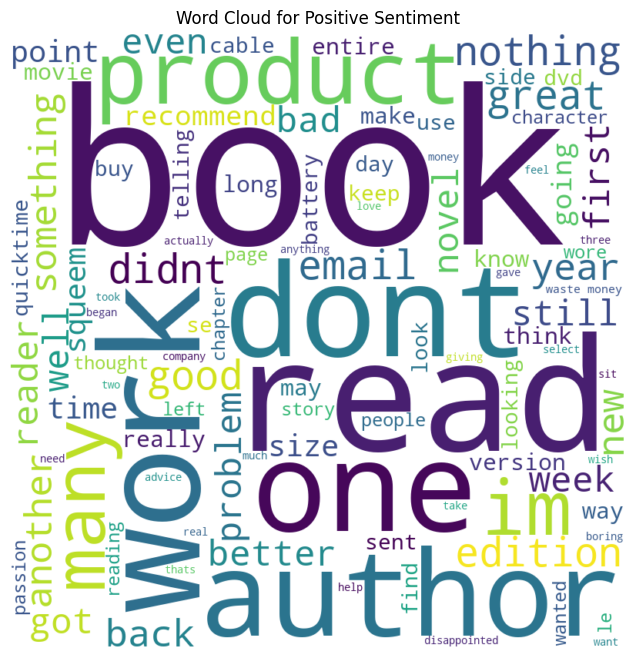

In [81]:
# Check the first few positive reviews before generating the word cloud
positive_reviews = data[data['Labels'] == '1']['processed_review'].head(50)  # Take a smaller subset
positive_text = ' '.join(positive_reviews)

if len(positive_text) > 0:
    wordcloud_positive = WordCloud(width=800, height=800, background_color='white', max_words=100).generate(positive_text)

    # Plot word cloud for positive sentiment
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Positive Sentiment')
    plt.show()
else:
    print("No positive reviews found to generate word cloud.")

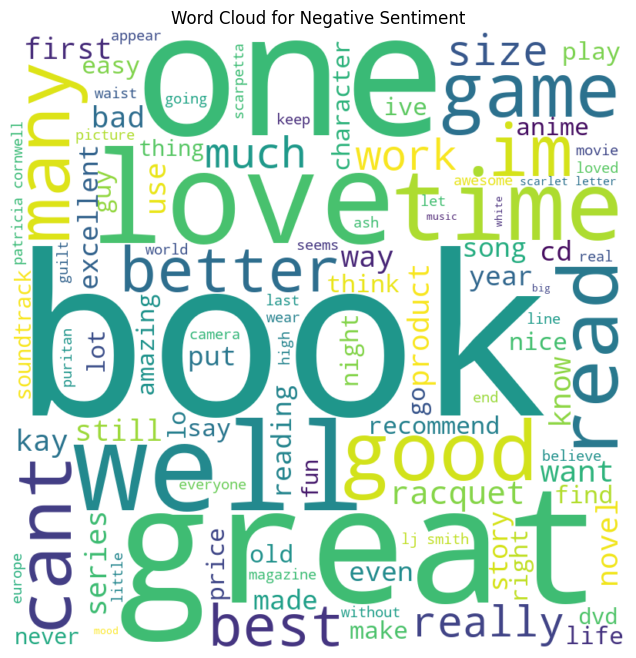

In [83]:
# Check the first few negative reviews before generating the word cloud
negative_reviews = data[data['Labels'] == '2']['processed_review'].head(50)  # Take a smaller subset of negative reviews
negative_text = ' '.join(negative_reviews)

if len(negative_text) > 0:
    wordcloud_negative = WordCloud(width=800, height=800, background_color='white', max_words=100).generate(negative_text)

    # Plot word cloud for negative sentiment
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Negative Sentiment')
    plt.show()
else:
    print("No negative reviews found to generate word cloud.")
